<a href="https://colab.research.google.com/github/tnnandi/RNN-MDN/blob/master/DeepLSTM_MDN_stateful_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
import numpy as np
np.random.seed(0)

input_file = 'CpLongDataAll_tap90B.txt'
#input_file = '/content/drive/My Drive/CpLongDataAll_tap90B.txt'
import pandas as pd

data = pd.read_csv(input_file, sep='\t', header=None)

In [0]:
Y = data.values.reshape(144000*28,1)
#X = Y[1*144000:194000]
XX = Y[1*144000:2*144000:1]
X = Y[1*144000:2*144000]

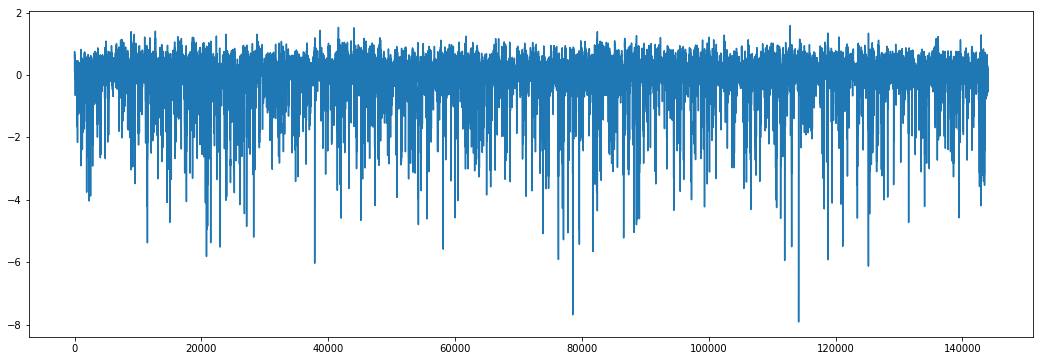

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 6))
plt.plot(XX)

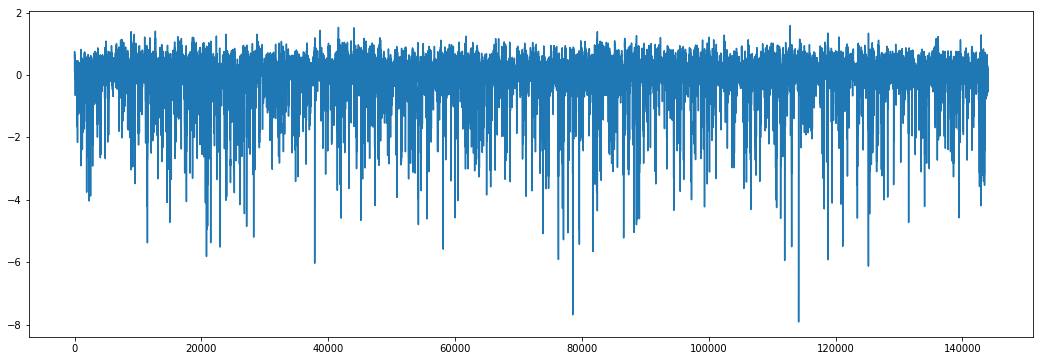

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 6))
plt.plot(X)

In [0]:
from sklearn.preprocessing import MaxAbsScaler, RobustScaler, StandardScaler, MinMaxScaler

scaler_train = StandardScaler()
#scaler_train = MinMaxScaler(feature_range=(0,1))
X = scaler_train.fit_transform(X)

In [0]:
import numpy as np
np.shape(X)

(144000, 1)

In [0]:
np.mean(X), np.std(X)

(-8.684411214845669e-18, 1.0)

# List all hyperparameters

In [0]:
# List all hyperparameters
from keras.optimizers import RMSprop, Adam

# Length of extracted time sequences
maxlen = 100#450#50

# We sample a new sequence every `step` time-step
# For stateful sequences, step should be equal to maxlen, as all sequences need to be non-overlapping (also in order, set "Shuffle=False" in model.fit)
step = 1#maxlen

# Number of Gaussian Mixtures
n_mix = 15

# Batch size
batch_size = 5756  #4785#99#2870#1435    #4950#5500

#Optimizer
optimizer = RMSprop(lr=0.001, decay=0.0)

# number of neurons in LSTM units
rnn_units = 64

#Number of neurons in the hidden dense layer
hidden_units = 16

# Prepare data for feeding to the LSTM network

In [0]:
# This holds our extracted sequences
sequences = []

# This holds the targets (the follow-up value)
next_vals = []

for i in range(0, len(X) - maxlen, step):
    sequences.append(X[i: i + maxlen])
    next_vals.append(X[i + maxlen])

print("size of training data: ", len(X))    
print("Window size for time series forecasting: ", maxlen)
print('Number of sequences:', len(sequences))



size of training data:  144000
Window size for time series forecasting:  100
Number of sequences: 143900


In [0]:
x = sequences
y = next_vals

In [0]:
#x, np.shape(x)

# Create the Model (with 4 stacked LSTM + hidden dense layer + output dense layer)

In [0]:
from keras import layers
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam

# Format for LSTM layer: keras.layers.LSTM(units,  )
# units: dimensionality of the output space

# Define the model
model = Sequential()
#model.add(layers.LSTM(128, return_sequences = True, input_shape=(maxlen, 1)))
model.add(layers.LSTM(rnn_units, return_sequences = True, stateful = 'True', batch_size = batch_size, input_shape=(maxlen, 1), name='LSTM1'))
model.add(layers.LSTM(rnn_units, return_sequences = True, stateful = 'True', input_shape=(maxlen, 1), name='LSTM2'))
model.add(layers.LSTM(rnn_units, return_sequences = True, stateful = 'True', input_shape=(maxlen, 1), name='LSTM3'))
model.add(layers.LSTM(rnn_units, return_sequences = True, stateful = 'True', input_shape=(maxlen, 1), name='LSTM4'))
model.add(layers.Flatten(name='Flatten')) # Added to make the final dense layer input shape compatible with the output of LSTM with "return_sequence=True"
#model.add(layers.Dense(1, activation='sigmoid'))
model.add(layers.Dense(hidden_units, activation='sigmoid'))
model.add(layers.Dense(3*n_mix, activation='linear', name='DenseFinal'))

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM1 (LSTM)                 (5756, 100, 64)           16896     
_________________________________________________________________
LSTM2 (LSTM)                 (5756, 100, 64)           33024     
_________________________________________________________________
LSTM3 (LSTM)                 (5756, 100, 64)           33024     
_________________________________________________________________
LSTM4 (LSTM)                 (5756, 100, 64)           33024     
_________________________________________________________________
Flatten (Flatten)            (5756, 6400)              0         
_________________________________________________________________
dense_2 (Dense)              (5756, 16)                102416    
_________________________________________________________________
DenseFinal (Dense)           (5756, 45)               

# Create the custom loss function

In [0]:
#In MDNs, instead of modeling the input (x) -> target (y) mapping by explicitly generating the output values, we learn the probability distribution of EACH TARGET 
#and sample the PREDICTED OUTPUT \hat{y} yHat from that distribution.

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from keras import backend as K
 
  
def mdn_loss(target, dense_output):
    """MDN Loss Function
    The eager mode in tensorflow 2.0 makes is extremely easy to write 
    functions like these. It feels a lot more pythonic to me.
    """
   

    mu_tmp = dense_output[:,:n_mix]   # CHECK these sizes
    sigma_tmp = dense_output[:, n_mix:2*n_mix]
    pi_tmp = dense_output[:, 2*n_mix:]    

    
    mu = mu_tmp
    sigma = tf.exp(sigma_tmp/2.0) # Standard deviation
    pi = tf.nn.softmax(pi_tmp)
    
    # find the likelihood of target from each mixture 
    out = tfd.Normal(mu, sigma).prob(tf.reshape(target,(-1,1)))
    # multiply with each pi and sum it
    out = tf.multiply(out, pi)
    out = tf.reduce_sum(out, 1, keepdims=True)
    out = -tf.math.log(out + 1e-10)
    out = tf.reduce_mean(out)
    #out = tf.reduce_mean(np.square(dense_output - target),axis=0)
    return out

# Compile the model

In [0]:
model.compile(loss=mdn_loss, optimizer=optimizer)


In [0]:
np.shape(np.array(x)), np.shape(np.array(y))

((143900, 100, 1), (143900, 1))

Updatable plot for loss function during training

In [0]:
# updatable plot (grabbed from stack Overflow)

import keras

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        #clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [0]:
# Recreate the exact same model, including weights and optimizer.
# import keras
# model = keras.models.load_model('savedModel.01.hdf5', custom_objects={'mdn_loss':mdn_loss})
# model.summary()
# batch_size = 5756

# Do the training

epoch =  0
Epoch 1/1
 - 22s - loss: 0.1178


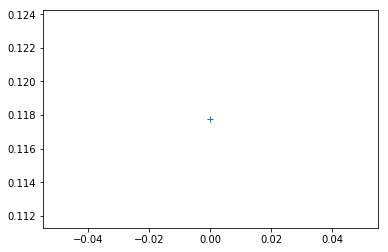

epoch =  1
Epoch 1/1
 - 20s - loss: 0.0791


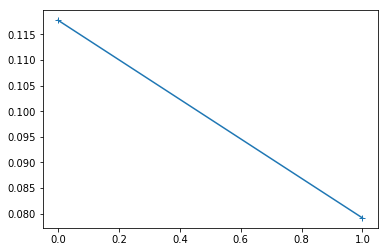

epoch =  2
Epoch 1/1
 - 20s - loss: 0.0798


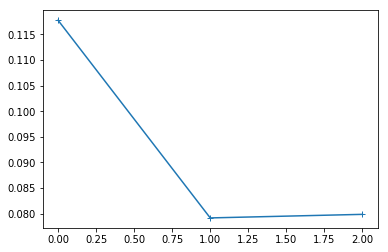

epoch =  3
Epoch 1/1
 - 20s - loss: 0.0700


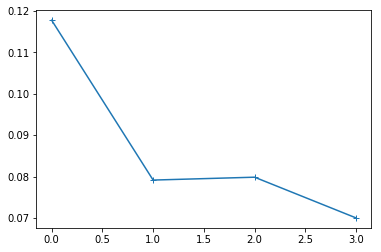

epoch =  4
Epoch 1/1
 - 20s - loss: 0.0642


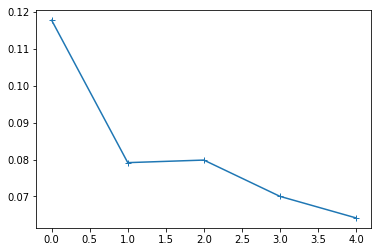

epoch =  5
Epoch 1/1
 - 20s - loss: 0.0693


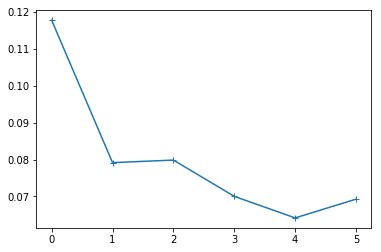

epoch =  6
Epoch 1/1
 - 20s - loss: 0.0616


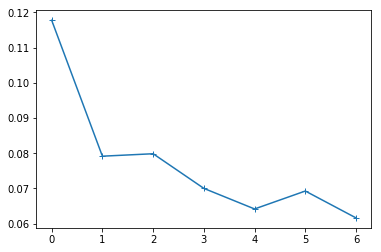

epoch =  7
Epoch 1/1
 - 20s - loss: 0.0609


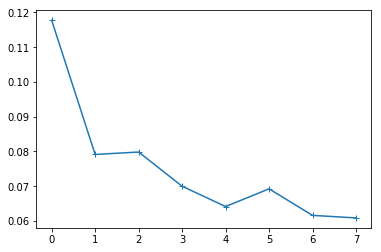

epoch =  8
Epoch 1/1
 - 20s - loss: 0.0672


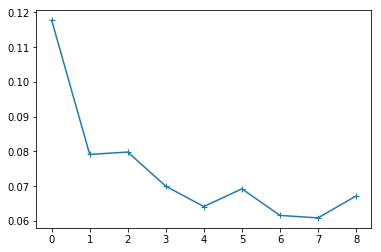

epoch =  9
Epoch 1/1
 - 20s - loss: 0.0594


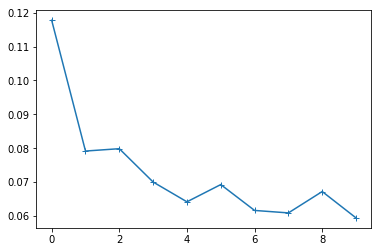

epoch =  10
Epoch 1/1
 - 20s - loss: 0.0541


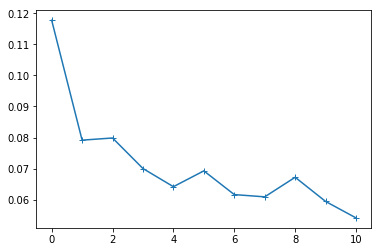

epoch =  11
Epoch 1/1
 - 20s - loss: 0.0546


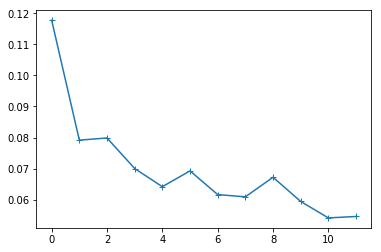

epoch =  12
Epoch 1/1
 - 20s - loss: 0.0510


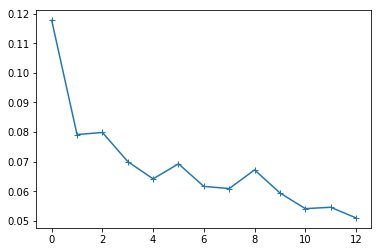

epoch =  13
Epoch 1/1
 - 20s - loss: 0.0466


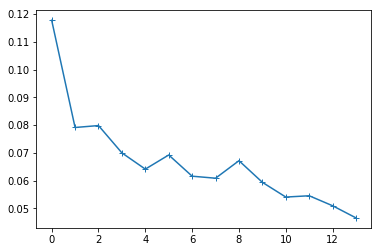

epoch =  14
Epoch 1/1
 - 20s - loss: 0.0477


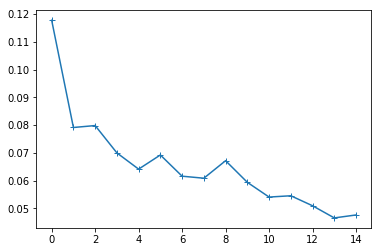

epoch =  15
Epoch 1/1
 - 20s - loss: 0.0420


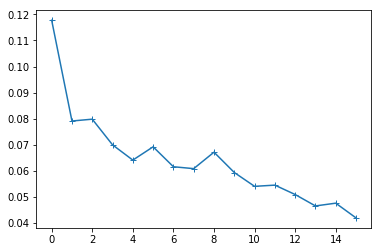

epoch =  16
Epoch 1/1
 - 20s - loss: 0.0422


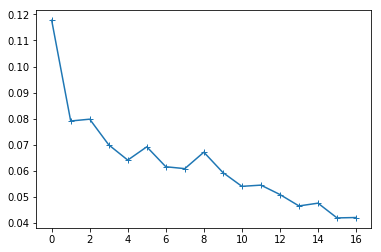

epoch =  17
Epoch 1/1
 - 20s - loss: 0.0387


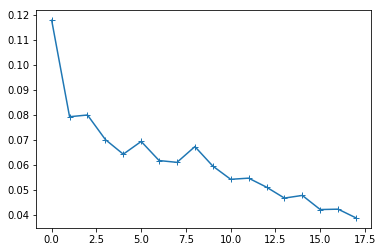

epoch =  18
Epoch 1/1
 - 20s - loss: 0.0378


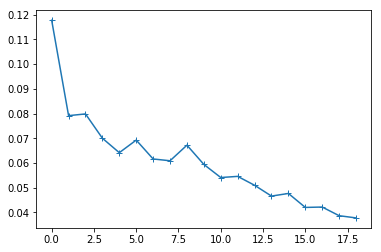

epoch =  19
Epoch 1/1
 - 20s - loss: 0.0385


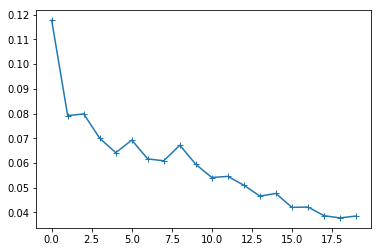

epoch =  20
Epoch 1/1
 - 20s - loss: 0.0362


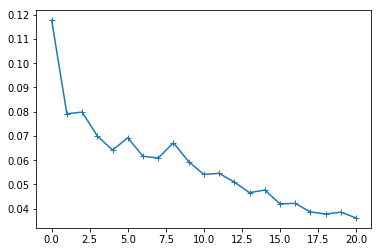

epoch =  21
Epoch 1/1
 - 20s - loss: 0.0324


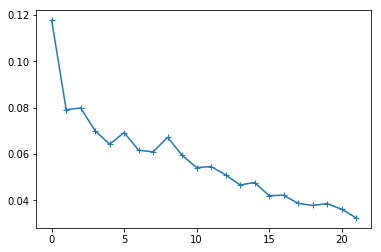

epoch =  22
Epoch 1/1
 - 20s - loss: 0.0306


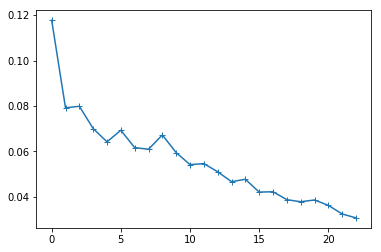

epoch =  23
Epoch 1/1
 - 20s - loss: 0.0262


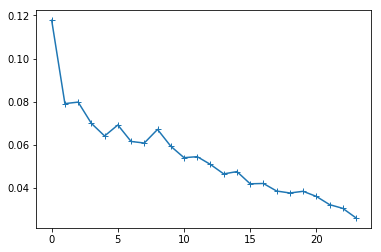

epoch =  24
Epoch 1/1
 - 20s - loss: 0.0227


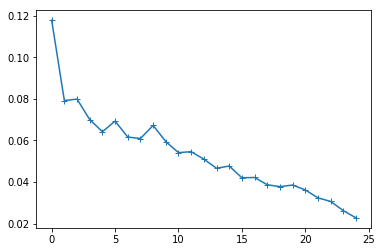

epoch =  25
Epoch 1/1
 - 20s - loss: 0.0226


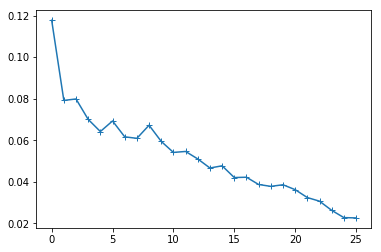

epoch =  26
Epoch 1/1
 - 20s - loss: 0.0251


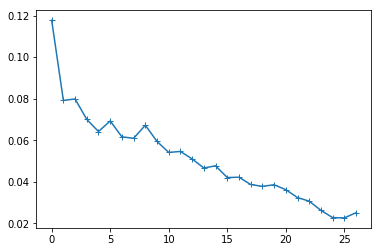

epoch =  27
Epoch 1/1
 - 20s - loss: 0.0206


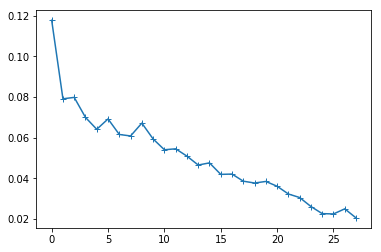

epoch =  28
Epoch 1/1
 - 20s - loss: 0.0124


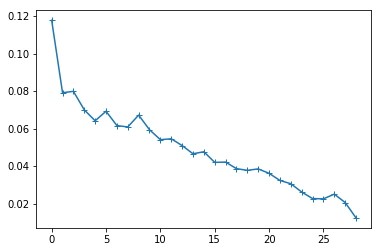

epoch =  29
Epoch 1/1
 - 20s - loss: 0.0156


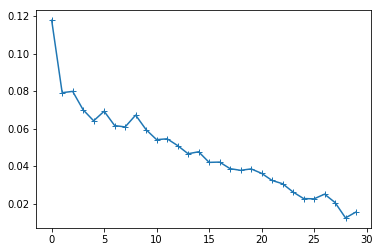

epoch =  30
Epoch 1/1
 - 20s - loss: 0.0041


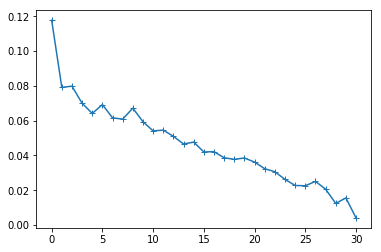

epoch =  31
Epoch 1/1
 - 20s - loss: 0.0133


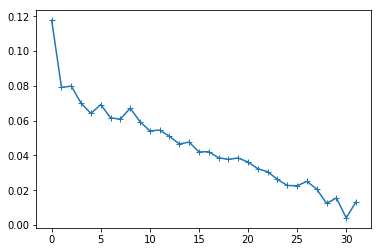

epoch =  32
Epoch 1/1
 - 20s - loss: 0.0081


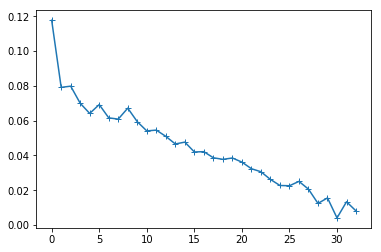

epoch =  33
Epoch 1/1
 - 20s - loss: 0.0067


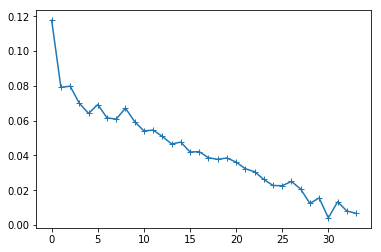

epoch =  34
Epoch 1/1
 - 20s - loss: -9.8085e-04


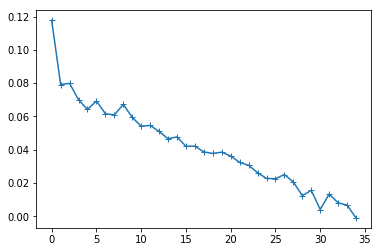

epoch =  35
Epoch 1/1
 - 20s - loss: -5.4659e-03


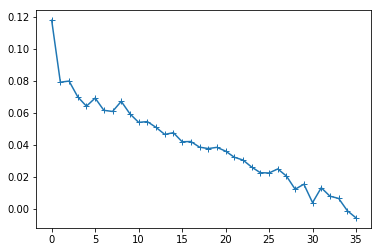

epoch =  36
Epoch 1/1
 - 20s - loss: 0.0028


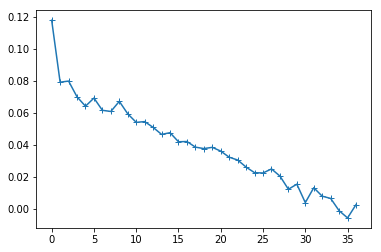

epoch =  37
Epoch 1/1
 - 20s - loss: -4.1426e-03


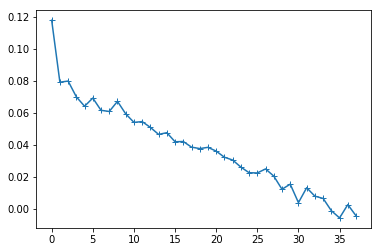

epoch =  38
Epoch 1/1
 - 20s - loss: -1.1753e-02


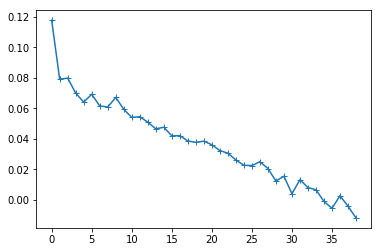

epoch =  39
Epoch 1/1
 - 20s - loss: -7.0745e-03


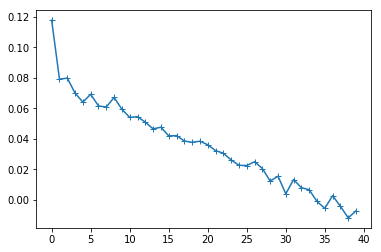

epoch =  40
Epoch 1/1
 - 20s - loss: -1.2980e-02


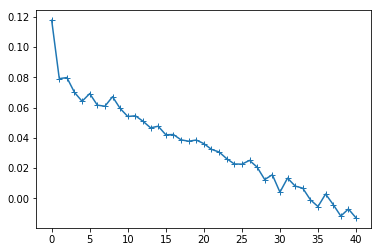

epoch =  41
Epoch 1/1
 - 20s - loss: -1.8109e-02


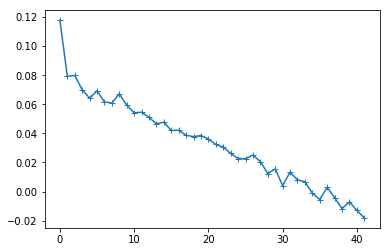

epoch =  42
Epoch 1/1
 - 20s - loss: -1.4065e-02


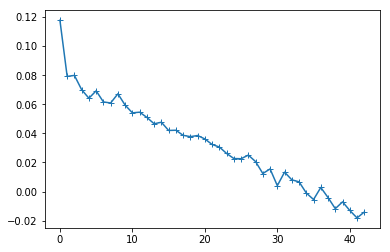

epoch =  43
Epoch 1/1
 - 20s - loss: -1.9004e-02


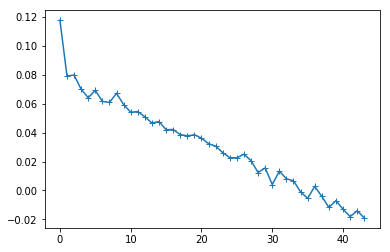

epoch =  44
Epoch 1/1
 - 20s - loss: -2.5159e-02


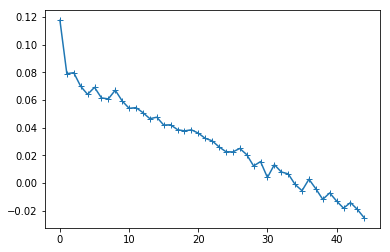

epoch =  45
Epoch 1/1
 - 20s - loss: -2.3084e-02


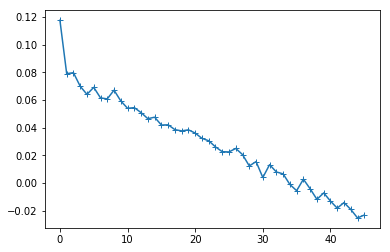

epoch =  46
Epoch 1/1
 - 20s - loss: -2.8406e-02


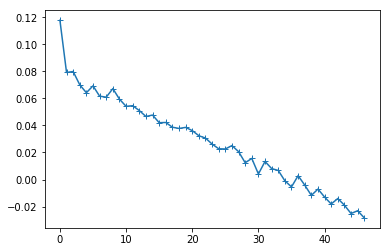

epoch =  47
Epoch 1/1
 - 20s - loss: -3.0731e-02


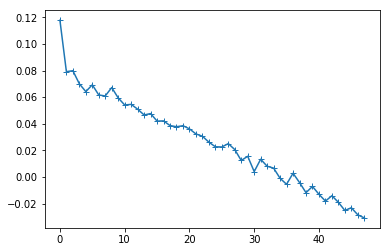

epoch =  48
Epoch 1/1
 - 20s - loss: -2.9936e-02


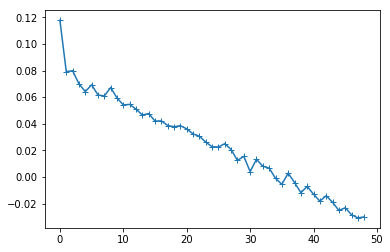

epoch =  49
Epoch 1/1
 - 20s - loss: -3.6046e-02

Epoch 00001: saving model to savedModel.01.hdf5


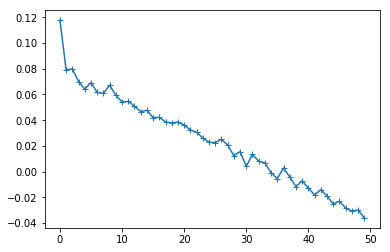

epoch =  50
Epoch 1/1
 - 20s - loss: -3.2486e-02


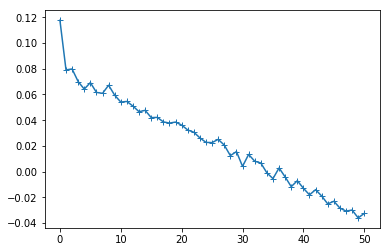

epoch =  51
Epoch 1/1
 - 20s - loss: -3.9220e-02


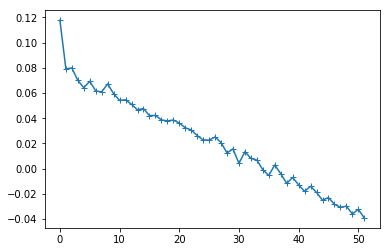

epoch =  52
Epoch 1/1
 - 20s - loss: -4.1086e-02


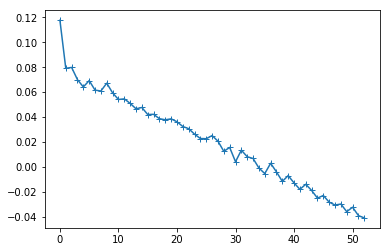

epoch =  53
Epoch 1/1
 - 20s - loss: -4.4268e-02


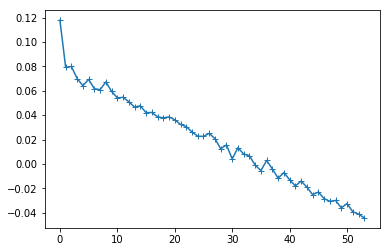

epoch =  54
Epoch 1/1
 - 20s - loss: -4.8506e-02


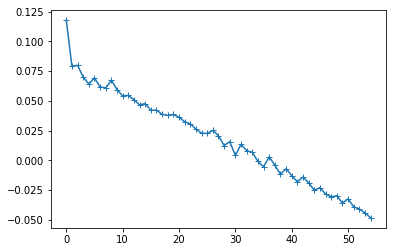

epoch =  55
Epoch 1/1
 - 20s - loss: -4.6491e-02


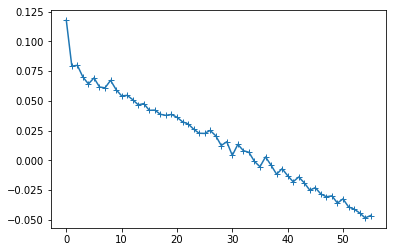

epoch =  56
Epoch 1/1
 - 20s - loss: -5.5403e-02


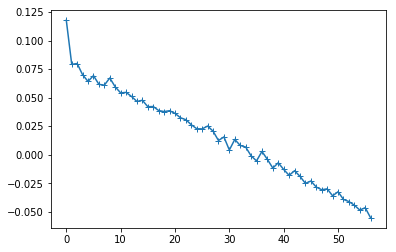

epoch =  57
Epoch 1/1
 - 20s - loss: -5.4608e-02


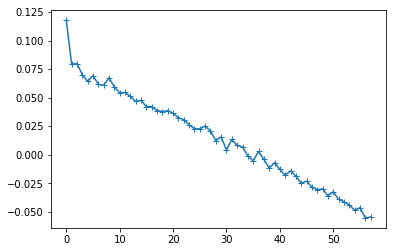

epoch =  58
Epoch 1/1
 - 20s - loss: -5.1948e-02


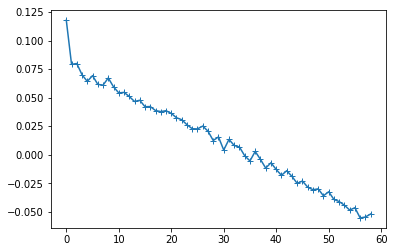

epoch =  59
Epoch 1/1
 - 20s - loss: -6.1895e-02


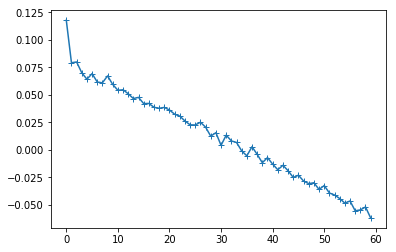

epoch =  60
Epoch 1/1
 - 20s - loss: -5.8695e-02


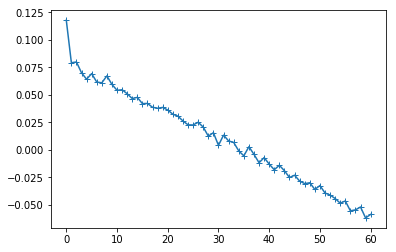

epoch =  61
Epoch 1/1
 - 20s - loss: -6.3999e-02


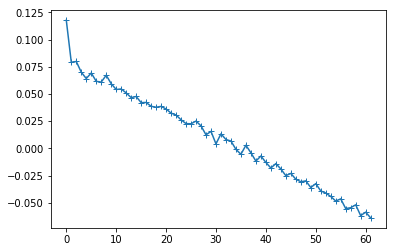

epoch =  62
Epoch 1/1
 - 20s - loss: -6.8833e-02


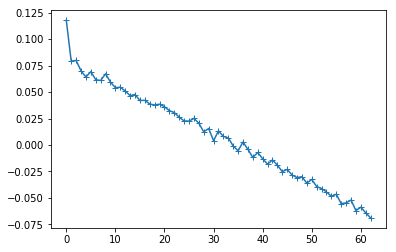

epoch =  63
Epoch 1/1
 - 20s - loss: -5.7238e-02


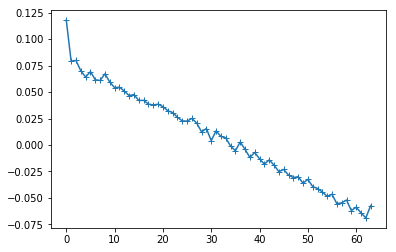

epoch =  64
Epoch 1/1
 - 20s - loss: -7.4676e-02


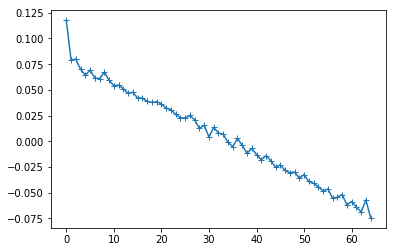

epoch =  65
Epoch 1/1
 - 20s - loss: -7.1983e-02


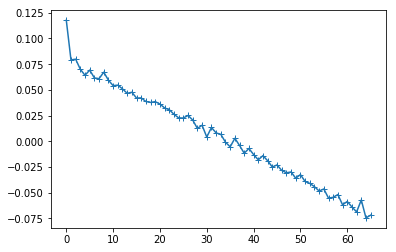

epoch =  66
Epoch 1/1
 - 20s - loss: -7.9176e-02


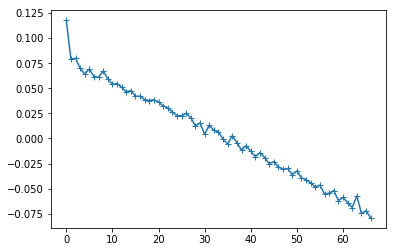

epoch =  67
Epoch 1/1
 - 20s - loss: -7.6850e-02


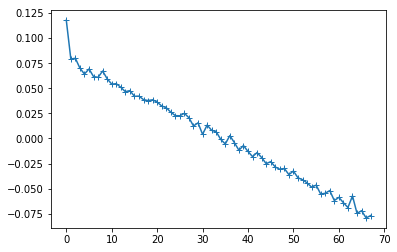

epoch =  68
Epoch 1/1
 - 20s - loss: -7.7698e-02


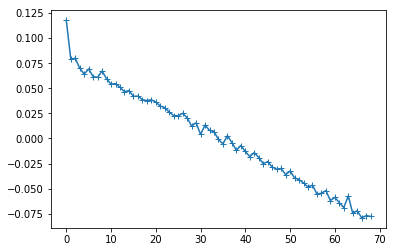

epoch =  69
Epoch 1/1
 - 20s - loss: -8.0152e-02


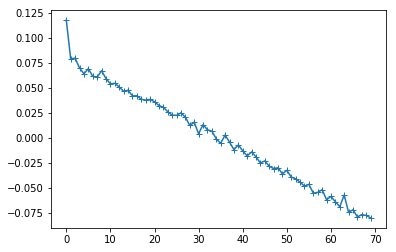

epoch =  70
Epoch 1/1
 - 20s - loss: -8.6277e-02


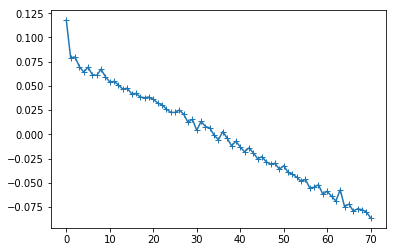

epoch =  71
Epoch 1/1
 - 20s - loss: -8.6709e-02


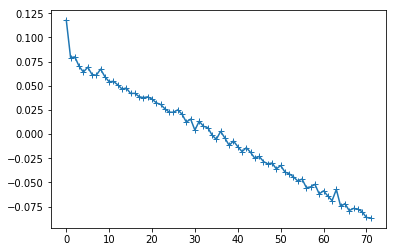

epoch =  72
Epoch 1/1
 - 20s - loss: -8.6818e-02


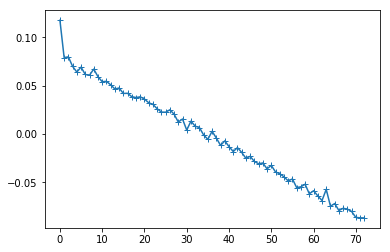

epoch =  73
Epoch 1/1
 - 20s - loss: -9.1997e-02


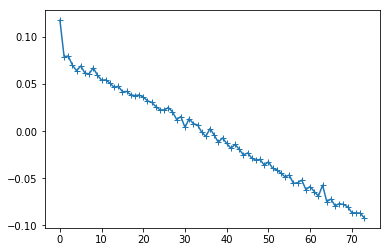

epoch =  74
Epoch 1/1
 - 20s - loss: -8.8455e-02


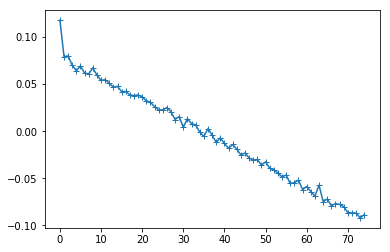

epoch =  75
Epoch 1/1
 - 20s - loss: -9.7119e-02


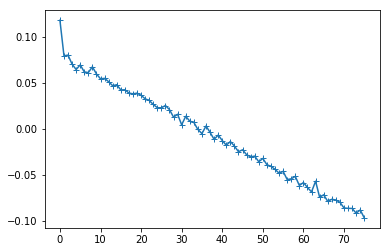

epoch =  76
Epoch 1/1
 - 20s - loss: -1.0202e-01


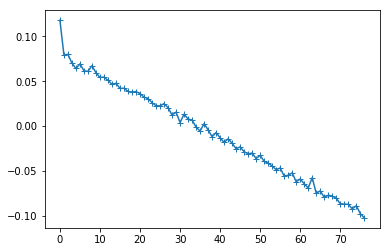

epoch =  77
Epoch 1/1
 - 20s - loss: -9.9359e-02


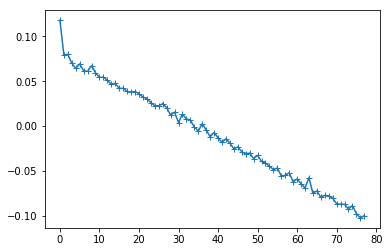

epoch =  78
Epoch 1/1
 - 20s - loss: -1.1059e-01


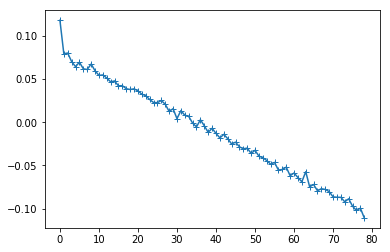

epoch =  79
Epoch 1/1
 - 20s - loss: -1.0538e-01


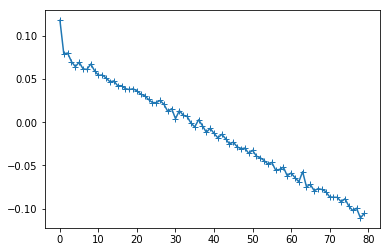

In [0]:
#https://keras.io/getting-started/faq/
import matplotlib.pyplot as plt
%matplotlib inline

num_epochs =80

saveModel = keras.callbacks.ModelCheckpoint(
                                            'savedModel.{epoch:02d}.hdf5', monitor='val_loss', verbose=1, save_best_only=False, 
                                             save_weights_only=False, mode='auto', period=50)

epochLossAll = []
for i in range(num_epochs):
  print("epoch = ", i)
  history = model.fit(np.array(x), np.array(y),
              #batch_size=256,
              shuffle=False, # Critical for stateful LSTM
              batch_size=batch_size, # try as large as possible before going out of memory
              epochs=1,
              verbose = 2,
              callbacks=[saveModel])
  epochLossAll.append(history.history['loss'])
  plt.plot(epochLossAll, '-+')  
  plt.show()
  model.reset_states()



In [0]:
# import keras
# model = keras.models.load_model('savedModel.01.hdf5', custom_objects={'mdn_loss':mdn_loss})
# model.summary()

In [0]:
model.get_layer('DenseFinal')

In [0]:
# View the output Gaussian mixtures. Get the output from the final dense layer
from keras.models import Model

layer_name = 'DenseFinal'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(np.array(x), batch_size = batch_size)

print(intermediate_output)
# model.summary()
# finalLayer_output = Model.get_layer('DenseFinal').output
# #W = np.squeeze(W)
# m = model(inputs=model.input, outputs=finalLayer_output)
# print(m.predict(np.array(x)))

[[ 0.40557015 -0.46470135  0.52665675 ... -0.19431941 -1.0609092
  -1.9893113 ]
 [ 0.56663674 -0.71040994  0.4362482  ... -0.15311094 -0.77531016
  -1.4598887 ]
 [ 0.5051791  -0.49332654  0.5271384  ... -0.15243699 -1.0432214
  -1.6772987 ]
 ...
 [ 0.24344519 -0.7440013   0.316442   ... -0.15125862 -0.77370054
  -1.2220659 ]
 [ 0.1495626  -0.30827695  0.14548512 ...  0.12953544 -0.50303465
  -1.8077984 ]
 [ 0.49738935  0.08603576  0.3124061  ...  0.02244101 -0.81164396
  -2.4621425 ]]


In [0]:
np.shape(intermediate_output)

(143900, 45)

In [0]:
import matplotlib.pyplot as plt
#plt.plot(intermediate_output[-2000,:], '+')
output = intermediate_output[-1,:]

In [0]:
#output = model.predict(np.array(x), batch_size = 256, verbose = 1)

In [0]:
np.shape(output)

(45,)

In [0]:
#plt.plot(output[:,:])

In [0]:
from scipy.special import softmax
mu_tmp = output[:n_mix]
sigma_tmp = output[n_mix:2*n_mix]
pi_tmp = output[2*n_mix:]

mu = mu_tmp
sigma = np.exp(sigma_tmp/2.0)
#sigma = np.abs(sigma_tmp)
pi = softmax(pi_tmp)


In [0]:
mu_tmp, sigma_tmp, pi_tmp

(array([ 4.9738935e-01,  8.6035758e-02,  3.1240609e-01, -1.7965585e-04,
        -2.9589364e-01,  9.4269976e-02,  3.5867903e-01,  4.4817805e-01,
         4.4222862e-02,  2.9775766e-01, -1.0995585e-01, -1.9852843e-02,
         2.8458002e-01,  2.2027619e-01, -2.0943019e-01], dtype=float32),
 array([-3.1853614, -2.8526292, -6.753285 , -5.90416  , -4.7444887,
        -4.168181 , -7.1205997, -2.1056767, -3.0812728, -1.8455415,
        -4.2783422, -5.0461516, -5.4797745, -6.5119762, -0.272873 ],
       dtype=float32),
 array([-0.62424064, -0.5131432 , -2.4918756 ,  1.7290435 , -2.4050233 ,
         2.5925949 , -0.98091006, -4.0774517 , -0.78483796, -2.227753  ,
        -2.355497  ,  1.0453571 ,  0.02244101, -0.81164396, -2.4621425 ],
       dtype=float32))

([<matplotlib.lines.Line2D at 0x7f254390b208>], -0.000209938619267821)

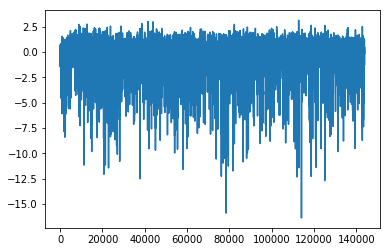

In [0]:
plt.plot(y), np.mean(y)

In [0]:
np.shape(X), np.shape(y)

((144000, 1), (143900, 1))

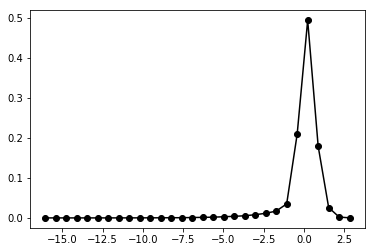

In [0]:
def plotPdf(data, nBins):
  heights_all,bins_all = np.histogram(data, bins=nBins)
  # Normalize and get the pdf
  heights_all = heights_all/float(sum(heights_all))
  binMids_all=bins_all[:-1]+np.diff(bins_all)/2.
  return heights_all, binMids_all

heights_real, binMids_real = plotPdf(X, 30)

plt.plot(binMids_real,heights_real, 'k-o')

In [0]:
np.shape(mu)

(15,)

In [0]:
mu, sigma,pi

(array([ 4.9738935e-01,  8.6035758e-02,  3.1240609e-01, -1.7965585e-04,
        -2.9589364e-01,  9.4269976e-02,  3.5867903e-01,  4.4817805e-01,
         4.4222862e-02,  2.9775766e-01, -1.0995585e-01, -1.9852843e-02,
         2.8458002e-01,  2.2027619e-01, -2.0943019e-01], dtype=float32),
 array([0.20337968, 0.2401925 , 0.03416196, 0.05223095, 0.09327116,
        0.12442023, 0.0284303 , 0.34894592, 0.21424471, 0.39741638,
        0.1177524 , 0.08021251, 0.06457763, 0.03854272, 0.87246174],
       dtype=float32),
 array([0.02079926, 0.02324326, 0.00321325, 0.21880953, 0.0035048 ,
        0.5189217 , 0.01455956, 0.00065817, 0.01771338, 0.00418458,
        0.00368276, 0.11044475, 0.03970984, 0.01724486, 0.00331022],
       dtype=float32))

In [0]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import scipy.stats as stats


# #xx = np.linspace(mu[0] - 3*sigma[0], mu[0] + 3*sigma[0], 100)
# xx = np.linspace(-4,2,1000)
# plt.plot(xx, stats.norm.pdf(xx, mu[0], sigma[0]))
# plt.show()



In [0]:
nPoints = 30

xx = np.linspace(min(X),max(X),nPoints)

pdf = np.zeros([nPoints,])
for i in range(n_mix-1):
  pdf = pdf + pi[i]*stats.norm.pdf(xx, mu[i], sigma[i])
  
plt.plot(xx,pdf, 'b')
plt.plot(xx, stats.norm.pdf(xx, mu[0], sigma[0]), 'k') # Uses the GMM parameters after the first epoch
plt.plot(binMids_real,heights_real, 'k-o')
  

In [0]:
plt.plot(xx,pdf, 'b')
plt.xlim([-5,3])

In [0]:
plt.semilogy(xx,pdf, 'b')
#plt.semilogy(xx, stats.norm.pdf(xx, mu[0], sigma[0]), 'k')
plt.semilogy(binMids_real,heights_real, 'k-o')

In [0]:
#heights_real, pdf

In [0]:
np.min(y), np.mean(y), np.max(y)

(-16.376724597333226, -0.000209938619267821, 3.1505638032708845)

In [0]:
# model.save("test.h5")
# print("Model saved")

In [0]:
# from google.colab import files
# files.download('fruits.h5')

In [0]:
# Recreate the exact same model, including weights and optimizer.
# import keras
# new_model = keras.models.load_model('test.h5', custom_objects={'mdn_loss':mdn_loss})
# new_model.summary()

In [0]:
#Predict the LSTM network output
preds = model.predict(np.array(x), verbose=1, batch_size=batch_size)

143900/143900 [==============================] - 8s 56us/step


In [0]:
np.shape(preds)

(143900, 45)

In [0]:
test = np.random.uniform()
print(test)

0.7913001089353453


# Generate a sequence from a seed time series


([<matplotlib.lines.Line2D at 0x7f2543a4f470>], -8.684411214845669e-18, 1.0)

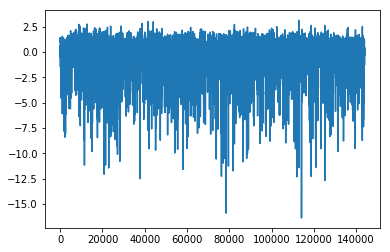

In [0]:
plt.plot(X), np.mean(X), np.std(X)

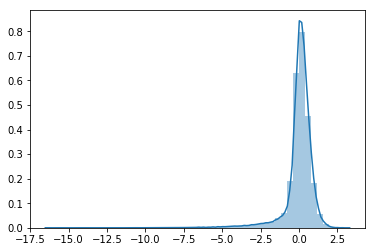

In [0]:
import seaborn as sns

sns.distplot(X)

In [0]:
mu, sigma, pi

(array([ 4.9738935e-01,  8.6035758e-02,  3.1240609e-01, -1.7965585e-04,
        -2.9589364e-01,  9.4269976e-02,  3.5867903e-01,  4.4817805e-01,
         4.4222862e-02,  2.9775766e-01, -1.0995585e-01, -1.9852843e-02,
         2.8458002e-01,  2.2027619e-01, -2.0943019e-01], dtype=float32),
 array([0.20337968, 0.2401925 , 0.03416196, 0.05223095, 0.09327116,
        0.12442023, 0.0284303 , 0.34894592, 0.21424471, 0.39741638,
        0.1177524 , 0.08021251, 0.06457763, 0.03854272, 0.87246174],
       dtype=float32),
 array([0.02079926, 0.02324326, 0.00321325, 0.21880953, 0.0035048 ,
        0.5189217 , 0.01455956, 0.00065817, 0.01771338, 0.00418458,
        0.00368276, 0.11044475, 0.03970984, 0.01724486, 0.00331022],
       dtype=float32))

In [0]:
np.shape(X)

(144000, 1)

In [0]:
# Create similar model as the trained one to avoid using the same batch_size

# re-define the batch size
batch_size_new = 1


# re-define model
new_model = Sequential()
new_model.add(layers.LSTM(rnn_units, return_sequences = True, stateful = 'False', batch_size = batch_size_new, input_shape=(maxlen, 1), name='LSTM1'))
new_model.add(layers.LSTM(rnn_units, return_sequences = True, stateful = 'False', input_shape=(maxlen, 1), name='LSTM2'))
new_model.add(layers.LSTM(rnn_units, return_sequences = True, stateful = 'True', input_shape=(maxlen, 1), name='LSTM3'))
new_model.add(layers.LSTM(rnn_units, return_sequences = True, stateful = 'True', input_shape=(maxlen, 1), name='LSTM4'))
new_model.add(layers.Flatten(name='Flatten')) # Added to make the final dense layer input shape compatible with the output of LSTM with "return_sequence=True"
new_model.add(layers.Dense(hidden_units, activation='sigmoid'))
new_model.add(layers.Dense(3*n_mix, activation='linear', name='DenseFinal'))

# copy weights
old_weights = model.get_weights()
new_model.set_weights(old_weights)

# Generate new samples

In [0]:
import scipy

seq = []
seq.append(np.random.uniform())
seq = X[:maxlen] # Use this as the seed

seq_len = 1000

for step in range(seq_len):
  print("step = ", step)
  #print("shape of preds = ", np.shape(preds))
  LSTM_input = seq[-maxlen:] # Extract only the last "maxlen" values for LSTM input
  #print("shape(LSTM_input) = ", np.shape(LSTM_input))
  LSTM_input = np.reshape(LSTM_input, ([-1, maxlen, 1]))
  pred = new_model.predict(LSTM_input, batch_size=1)
  #print(np.shape(pred))
  mu = pred[:, :n_mix]
  sigma = pred[:, n_mix:2*n_mix]
  pi = pred[:, 2*n_mix:]

  mu = np.squeeze(mu)
  sigma = np.squeeze(sigma)
  pi = np.squeeze(pi)
  
  sigma = np.exp(sigma/2.0) # Standard deviation
  pi = scipy.special.softmax(pi)
  #print("sigma = ", sigma)
  #print(type(n_mix))
  #print(type(pi))
  select_mixture = np.random.choice(n_mix, p=pi)
  #print("mixture component selected = ", select_mixture)
  new_pred = np.random.normal(loc=mu[select_mixture], scale= sigma[select_mixture])
  #print(new_pred)
  #scale = sigma[select_mixture]
  # print(np.shape(seq))
  # print(np.shape(new_pred))
  # print(type(seq))
  # print(seq)
  # print(new_pred)
  # Append the newly predicted value to the end of the seq array
  seq = np.append(np.squeeze(seq), new_pred)
  print("shape of generated sequence: ", np.shape(seq))
  

step =  0
shape of generated sequence:  (101,)
step =  1
shape of generated sequence:  (102,)
step =  2
shape of generated sequence:  (103,)
step =  3
shape of generated sequence:  (104,)
step =  4
shape of generated sequence:  (105,)
step =  5
shape of generated sequence:  (106,)
step =  6
shape of generated sequence:  (107,)
step =  7
shape of generated sequence:  (108,)
step =  8
shape of generated sequence:  (109,)
step =  9
shape of generated sequence:  (110,)
step =  10
shape of generated sequence:  (111,)
step =  11
shape of generated sequence:  (112,)
step =  12
shape of generated sequence:  (113,)
step =  13
shape of generated sequence:  (114,)
step =  14
shape of generated sequence:  (115,)
step =  15
shape of generated sequence:  (116,)
step =  16
shape of generated sequence:  (117,)
step =  17
shape of generated sequence:  (118,)
step =  18
shape of generated sequence:  (119,)
step =  19
shape of generated sequence:  (120,)
step =  20
shape of generated sequence:  (121,)
st

In [0]:
gen_seq = seq[maxlen:]

(-11, 2)

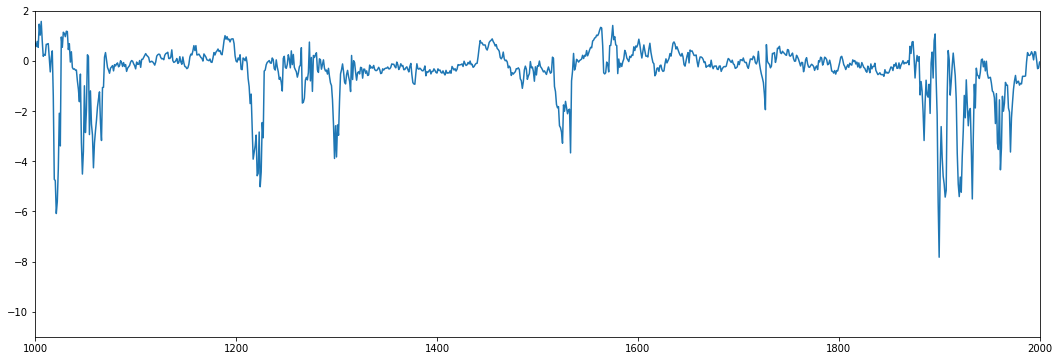

In [0]:
plt.figure(figsize=(18, 6))
plt.plot(X)
plt.xlim([1000,2000])
plt.ylim([-11,2])

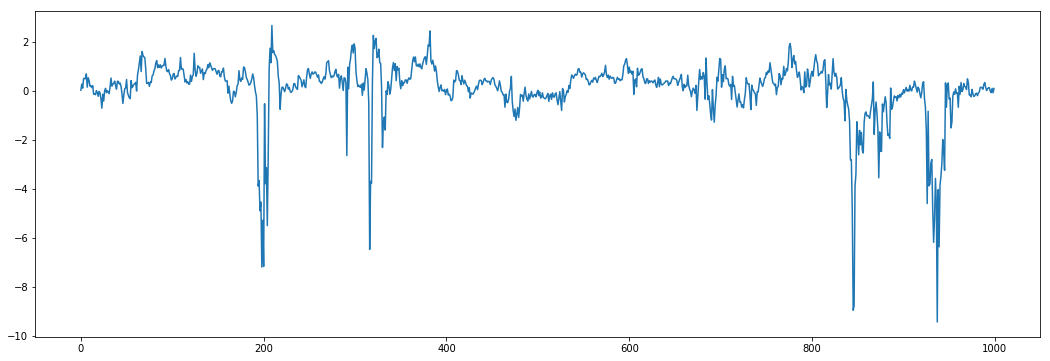

In [0]:
plt.figure(figsize=(18, 6))
plt.plot(gen_seq)
#plt.xlim([200,400])

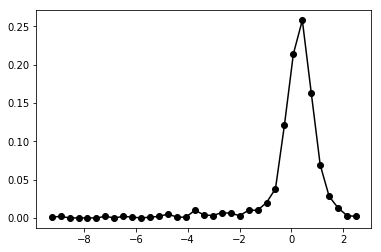

In [0]:
heights_synthetic, binMids_synthetic = plotPdf(gen_seq, 35)

plt.plot(binMids_synthetic,heights_synthetic, 'k-o')

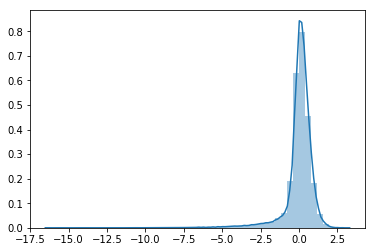

In [0]:
sns.distplot(X)
#sns.distplot(gen_seq)

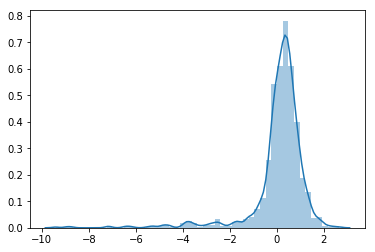

In [0]:
sns.distplot(gen_seq)

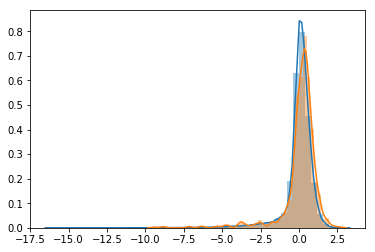

In [0]:
sns.distplot(X)
sns.distplot(gen_seq)

<Figure size 432x288 with 0 Axes>

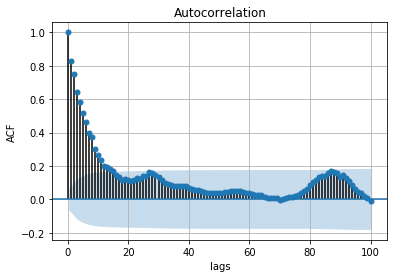

<Figure size 432x288 with 0 Axes>

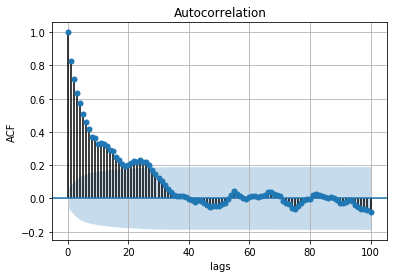

In [0]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(3)
plot_acf(gen_seq, lags=100)
#plot_acf(samples[:,0], lags=50)
plt.xlabel('lags')
plt.ylabel('ACF')
plt.grid()
plt.show()


plt.figure(3)
plot_acf(X[:1000], lags=100)
#plot_acf(X, lags=100)
#plot_acf(samples[:,0], lags=50)
plt.xlabel('lags')
plt.ylabel('ACF')
plt.grid()
plt.show()

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 14400 is greater than input length  = 1000, using nperseg = 1000
  .format(nperseg, input_length))


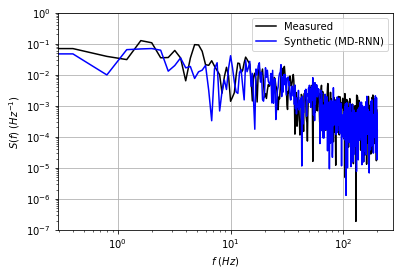

In [0]:
# Plot spectra
from scipy.signal import welch

sampling_rate = 400
nfft = 14400#10*14400
# Plot the scpectrum
def spectrum(data, nfft):
        x = data
        f,s = welch(x, sampling_rate, axis = 0, nperseg = nfft)
        return f,s

#f,s = spectrum(X[10000:15000])
f_90,s_90 = spectrum(X[:1000], nfft)
f_90_MDN,s_90_MDN = spectrum(gen_seq, nfft)

#fs_90 = [a*b for a,b in zip(f_90,s_90)]

#s_minusFiveThird = [i]

plt.figure(1)
plt.loglog(f_90,s_90, 'k', label = 'Measured')
#plt.loglog(f_90_HMM,s_90_HMM, 'r', label = 'Synthetic (HMM)')
plt.loglog(f_90_MDN,s_90_MDN, 'b', label = 'Synthetic (MD-RNN)')
#plt.loglog(f_90, 0.05*f_90**(-5/3), 'g', label = '-5/3 slope')
plt.ylim([1e-7,1e+0])
#plt.ylim([1e-5,1e-1])
#plt.xlim([1e-3,200])
plt.xlabel('$f\ (Hz)$')
plt.ylabel('$S(f)\  (Hz^{-1})$')
plt.legend()
plt.grid()
plt.show()


Given a trained model and a seed sequence, we generate new sequence by repeatedly:

1) Drawing from the model a probability distribution over the next value given the sequence available so far

2) Reweighting the distribution to a certain "temperature"

3) Sampling the next value at random according to the reweighted distribution

4) Adding the new value at the end of the available sequence